#(Teoria)Usar Delta Lake no Azure

## Compreender o Delta Lake

O Delta Lake é uma camada de armazenamento de código aberto que adiciona semântica de banco de dados relacional ao processamento do data lake baseado em Spark. O Delta Lake é compatível com pools do Spark do Azure Synapse Analytics para código PySpark, Scala e .NET.

Os benefícios de usar o Delta Lake em um pool do Spark do Synapse Analytics incluem:

Tabelas relacionais que dão suporte a consulta e modificação de dados.

Suporte para transações ACID.

Controle de versão de dados e viagem no tempo.

Suporte para dados em lote e de streaming.

Formatos padrão e interoperabilidade.

## Criar uma tabela do Delta Lake de um dataframe

Uma das maneiras mais fáceis de criar uma tabela do Delta Lake é salvar um dataframe no formato delta, especificando um caminho em que os arquivos de dados e as informações de metadados relacionadas para a tabela devem ser armazenados.

Por exemplo, o seguinte código PySpark carrega um dataframe contendo dados de um arquivo existente e, em seguida, salva esse dataframe em um novo local de pasta no formato delta:

In [ ]:
# Load a file into a dataframe
df = spark.read.load('/data/mydata.csv', format='csv', header=True)

# Save the dataframe as a delta table
delta_table_path = "/delta/mydata"
df.write.format("delta").save(delta_table_path)

Você pode substituir uma tabela do delta lake existente pelo conteúdo de um dataframe usando o modo de substituição, conforme mostrado aqui:

In [ ]:
new_df.write.format("delta").mode("overwrite").save(delta_table_path)

Você também pode adicionar linhas de um dataframe a uma tabela existente usando o modo de acréscimo:

In [ ]:
new_rows_df.write.format("delta").mode("append").save(delta_table_path)

Fazer atualizações condicionais

Por exemplo, você pode usar o seguinte código para atualizar a coluna price para todas as linhas com um valor de "Acessories" para a coluna category:

In [ ]:
from delta.tables import *
from pyspark.sql.functions import *

# Create a deltaTable object
deltaTable = DeltaTable.forPath(spark, delta_table_path)

# Update the table (reduce price of accessories by 10%)
deltaTable.update(
    condition = "Category == 'Accessories'",
    set = { "Price": "Price * 0.9" })

As modificações de dados são registradas no log de transações e novos arquivos parquet são criados na pasta da tabela, conforme necessário.

Consultar uma versão anterior de uma tabela

Você pode recuperar dados de uma versão específica de uma tabela do Delta Lake lendo os dados do local da tabela delta em um dataframe, especificando a versão necessária como uma opção versionAsOf:

In [ ]:
df = spark.read.format("delta").option("versionAsOf", 0).load(delta_table_path)

Como alternativa, você pode especificar um carimbo de data/hora usando a opção timestampAsOf:

df = spark.read.format("delta").option("timestampAsOf", '2022-01-01').load(delta_table_path)

## Uma tabela gerenciada

Uma tabela gerenciada é definida sem um local especificado, e os arquivos de dados são gravados no armazenamento usado pelo metastore. A remoção da tabela não apenas remove os metadados dela do catálogo, mas também exclui a pasta na qual os arquivos de dados da tabela estão armazenados.

## Uma tabela externa

Uma tabela externa é definida para um local de arquivo personalizado, onde os dados da tabela são armazenados. Os metadados da tabela são definidos no catálogo do Spark. Remover a tabela exclui os metadados do catálogo, mas não afeta os arquivos de dados.

## Criar tabelas de catálogo

Criar uma tabela de catálogo com base em um dataframe

Você pode criar tabelas gerenciadas escrevendo um dataframe usando a operação saveAsTable, conforme mostrado nos seguintes exemplos:

In [ ]:
# Save a dataframe as a managed table
df.write.format("delta").saveAsTable("MyManagedTable")

## specify a path option to save as an external table
df.write.format("delta").option("path", "/mydata").saveAsTable("MyExternalTable")

Criar uma tabela de catálogo usando SQL

Você também pode criar uma tabela de catálogo usando a instrução SQL CREATE TABLE com a cláusula USING DELTA e um parâmetro opcional LOCATION para tabelas externas. Você pode executar a instrução usando a API SparkSQL, como o seguinte exemplo:

In [ ]:
spark.sql("CREATE TABLE MyExternalTable USING DELTA LOCATION '/mydata'")

Como alternativa, você pode usar o suporte de SQL nativo no Spark para executar a instrução:

In [ ]:
%%sql

CREATE TABLE MyExternalTable
USING DELTA
LOCATION '/mydata'

## Definir o esquema de tabela

Em todos os exemplos até agora, a tabela é criada sem um esquema explícito. No caso de tabelas criadas escrevendo um dataframe, o esquema de tabela é herdado do dataframe. Ao criar uma tabela externa, o esquema é herdado de todos os arquivos armazenados atualmente no local da tabela. No entanto, ao criar uma tabela gerenciada ou uma tabela externa com um local vazio no momento, você define o esquema da tabela especificando os nomes de coluna, os tipos e a nulidade como parte da instrução CREATE TABLE; conforme mostrado no seguinte exemplo:

In [ ]:
%%sql

CREATE TABLE ManagedSalesOrders
(
    Orderid INT NOT NULL,
    OrderDate TIMESTAMP NOT NULL,
    CustomerName STRING,
    SalesTotal FLOAT NOT NULL
)
USING DELTA

Usando a API DeltaTableBuilder

Você pode usar a API DeltaTableBuilder (parte da API do Delta Lake) para criar uma tabela de catálogo, conforme mostrado no seguinte exemplo:

In [ ]:
from delta.tables import *

DeltaTable.create(spark) \
  .tableName("default.ManagedProducts") \
  .addColumn("Productid", "INT") \
  .addColumn("ProductName", "STRING") \
  .addColumn("Category", "STRING") \
  .addColumn("Price", "FLOAT") \
  .execute()

Usar tabelas de catálogo

Você pode usar tabelas de catálogo como tabelas em qualquer banco de dados relacional baseado em SQL, consultando e manipulando-as usando instruções de SQL padrão. Por exemplo, o seguinte exemplo de código usa uma instrução SELECT para consultar a tabela ManagedSalesOrders:

In [ ]:
%%sql

SELECT orderid, salestotal
FROM ManagedSalesOrders

## Streaming com tabelas do Delta Lake

Você pode usar uma tabela do Delta Lake como uma origem ou um coletor para o Streaming Estruturado do Spark.

Usar uma tabela do Delta Lake como uma origem de streaming

No exemplo de PySpark a seguir, uma tabela do Delta Lake é usada para armazenar detalhes de pedidos de vendas na Internet. Um fluxo é criado que lê dados da pasta da tabela do Delta Lake à medida que novos dados são acrescentados.

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

# Load a streaming dataframe from the Delta Table
stream_df = spark.readStream.format("delta") \
    .option("ignoreChanges", "true") \
    .load("/delta/internetorders")

# Now you can process the streaming data in the dataframe
# for example, show it:
stream_df.writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

Usar uma tabela do Delta Lake como um coletor de streaming

No exemplo de PySpark a seguir, um fluxo de dados é lido de arquivos JSON em uma pasta. Os dados JSON em cada arquivo contêm o status de um dispositivo IoT no formato {"device":"Dev1","status":"ok"} Novos dados são adicionados ao fluxo sempre que um arquivo é adicionado à pasta. O fluxo de entrada é um dataframe sem limites, que é gravado em formato delta em um local de pasta para uma tabela do Delta Lake.

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

# Create a stream that reads JSON data from a folder
inputPath = '/streamingdata/'
jsonSchema = StructType([
    StructField("device", StringType(), False),
    StructField("status", StringType(), False)
])
stream_df = spark.readStream.schema(jsonSchema).option("maxFilesPerTrigger", 1).json(inputPath)

# Write the stream to a delta table
table_path = '/delta/devicetable'
checkpoint_path = '/delta/checkpoint'
delta_stream = stream_df.writeStream.format("delta").option("checkpointLocation", checkpoint_path).start(table_path)

Depois que o processo de streaming for iniciado, você poderá consultar a tabela do Delta Lake na qual a saída de streaming está sendo gravada para ver os dados mais recentes. Por exemplo, o seguinte código cria uma tabela de catálogo para a pasta de tabela do Delta Lake e consulta essa tabela:

In [ ]:
%%sql

CREATE TABLE DeviceTable
USING DELTA
LOCATION '/delta/devicetable';

SELECT device, status
FROM DeviceTable;

Para impedir que o fluxo de dados seja gravado na tabela do Delta Lake, você pode usar o método stop da consulta de streaming:

In [ ]:
delta_stream.stop()

## Consultando arquivos formatados delta com OPENROWSET

O pool de SQL sem servidor no Azure Synapse Analytics inclui suporte para leitura de arquivos de formato delta; permitindo que você use o pool de SQL para consultar tabelas delta lake.

In [ ]:
SELECT *
FROM
    OPENROWSET(
        BULK 'https://mystore.dfs.core.windows.net/files/delta/mytable/',
        FORMAT = 'DELTA'
    ) AS deltadata

Você pode executar essa consulta em um pool de SQL sem servidor para recuperar os dados mais recentes da tabela Delta Lake armazenada no local do arquivo especificado.

Você também pode criar um banco de dados e adicionar uma fonte de dados que encapsula a localização dos arquivos de dados do Delta Lake, conforme mostrado neste exemplo:

In [ ]:
CREATE DATABASE MyDB
      COLLATE Latin1_General_100_BIN2_UTF8;
GO;

USE MyDB;
GO

CREATE EXTERNAL DATA SOURCE DeltaLakeStore
WITH
(
    LOCATION = 'https://mystore.dfs.core.windows.net/files/delta/'
);
GO

SELECT TOP 10 *
FROM OPENROWSET(
        BULK 'mytable',
        DATA_SOURCE = 'DeltaLakeStore',
        FORMAT = 'DELTA'
    ) as deltadata;

Consultando tabelas de catálogo

O pool de SQL sem servidor no Azure Synapse Analytics tem acesso compartilhado a bancos de dados no metastore do Spark, para que você possa consultar tabelas de catálogo que foram criadas usando o Spark SQL. No exemplo a seguir, uma consulta SQL em um pool de SQL sem servidor consulta uma tabela de catálogo que contém dados delta lake:

In [ ]:
-- By default, Spark catalog tables are created in a database named "default"
-- If you created another database using Spark SQL, you can use it here
USE default;

SELECT * FROM MyDeltaTable;

# (Lab Pratico)Usar Delta Lake no Azure

## Explore os dados no data lake

In [ ]:
 rm -r dp-203 -f
 git clone https://github.com/MicrosoftLearning/dp-203-azure-data-engineer dp-203

In [ ]:
cd dp-203/Allfiles/labs/07
 ./setup.ps1

O script provisiona um espaço de trabalho do Azure Synapse Analytics e uma conta de Armazenamento do Azure para hospedar o data lake e, em seguida, carrega um arquivo de dados no data lake.

Selecione products.csv e, na lista Novo notebook na barra de ferramentas, selecione Carregar no DataFrame.

resultado(Print do meu Synapse Studio):

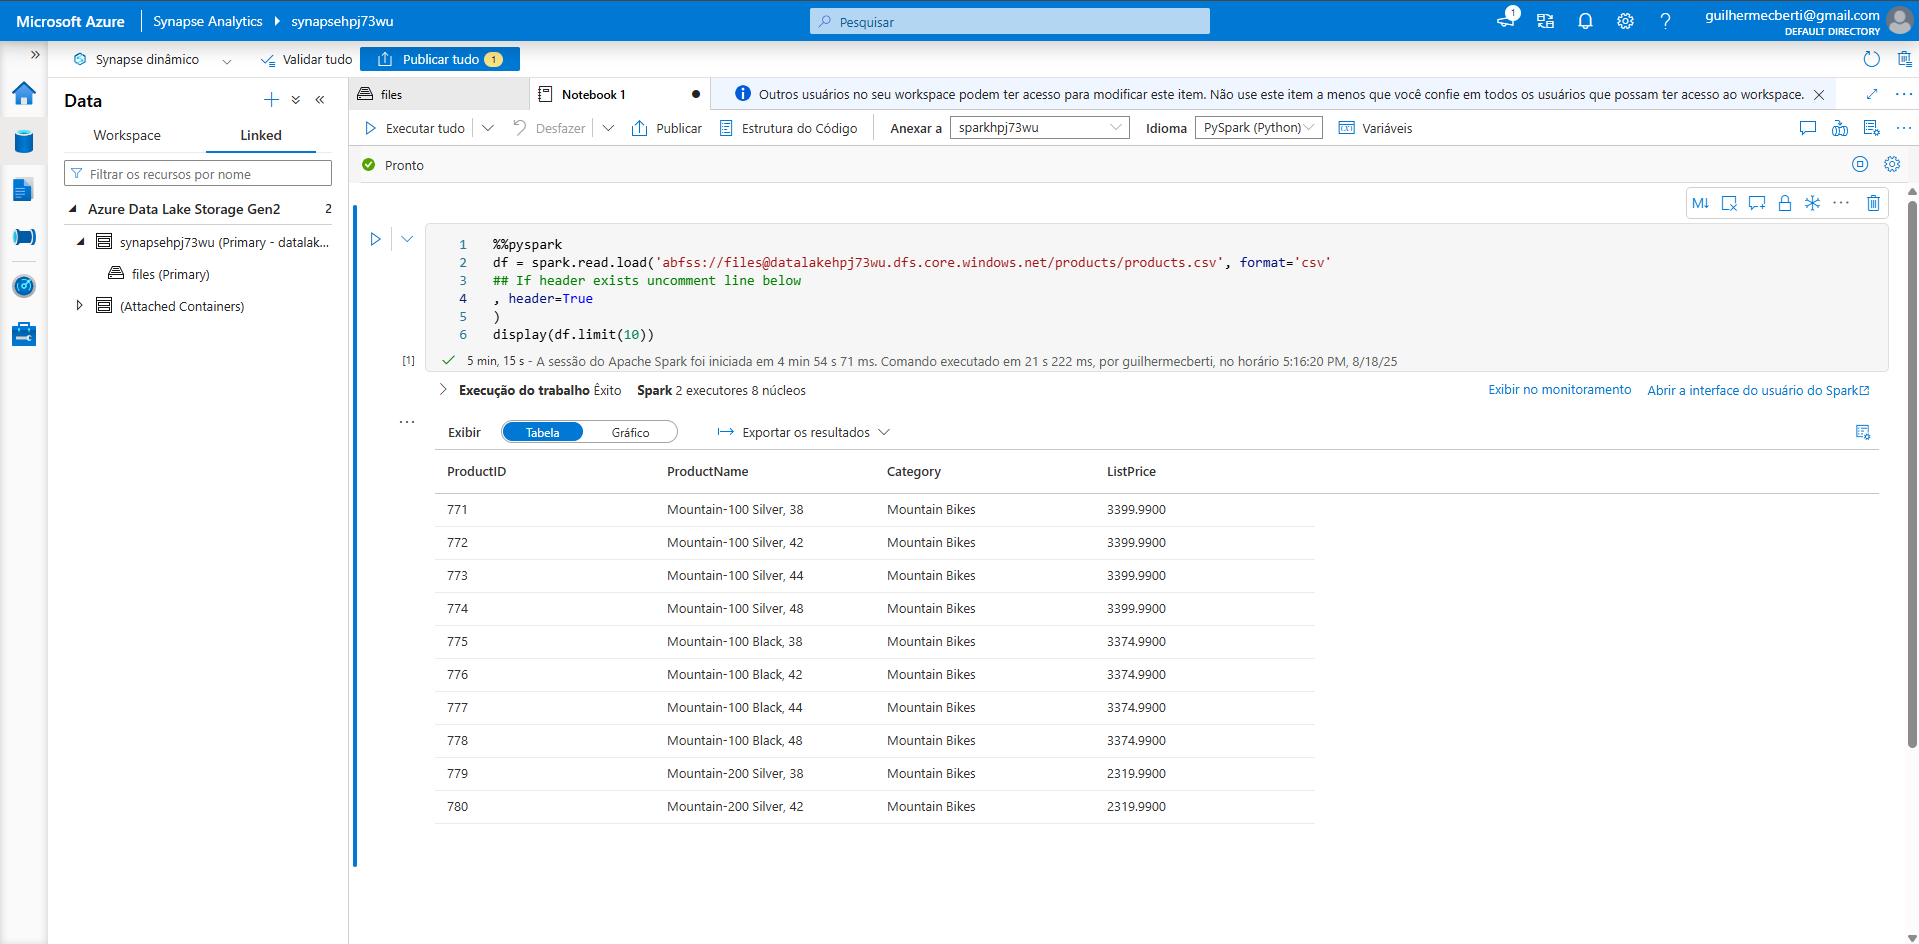

## Carregue os dados do arquivo em uma tabela delta

Abaixo dos resultados retornados pela primeira célula de código, use o botão + Código para adicionar uma nova célula de código. Em seguida, insira o seguinte código na nova célula e execute-o:

In [ ]:
df = spark.read.load('abfss://files@datalakehpj73wu.dfs.core.windows.net/products/products.csv', format='csv', header=True)
delta_table_path = "/delta/products-delta"
df.write.format("delta").save(delta_table_path)

Na aba de arquivos, use o ícone ↑ na barra de ferramentas para retornar à raiz do contêiner de arquivos e observe que uma nova pasta chamada delta foi criada. Abra essa pasta e a tabela products-delta que ela contém, onde você deverá ver o(s) arquivo(s) no formato parquet contendo os dados.

Em seguida, na nova célula, adicione o seguinte código e execute-o:

In [ ]:
 from delta.tables import *
 from pyspark.sql.functions import *

 # Create a deltaTable object
 deltaTable = DeltaTable.forPath(spark, delta_table_path)

 # Update the table (reduce price of product 771 by 10%)
 deltaTable.update(
     condition = "ProductID == 771",
     set = { "ListPrice": "ListPrice * 0.9" })

 # View the updated data as a dataframe
 deltaTable.toDF().show(10)

Os dados são carregados em um objeto DeltaTable e atualizados. Você pode ver a atualização refletida nos resultados da consulta(print de meu Synapse Studio):

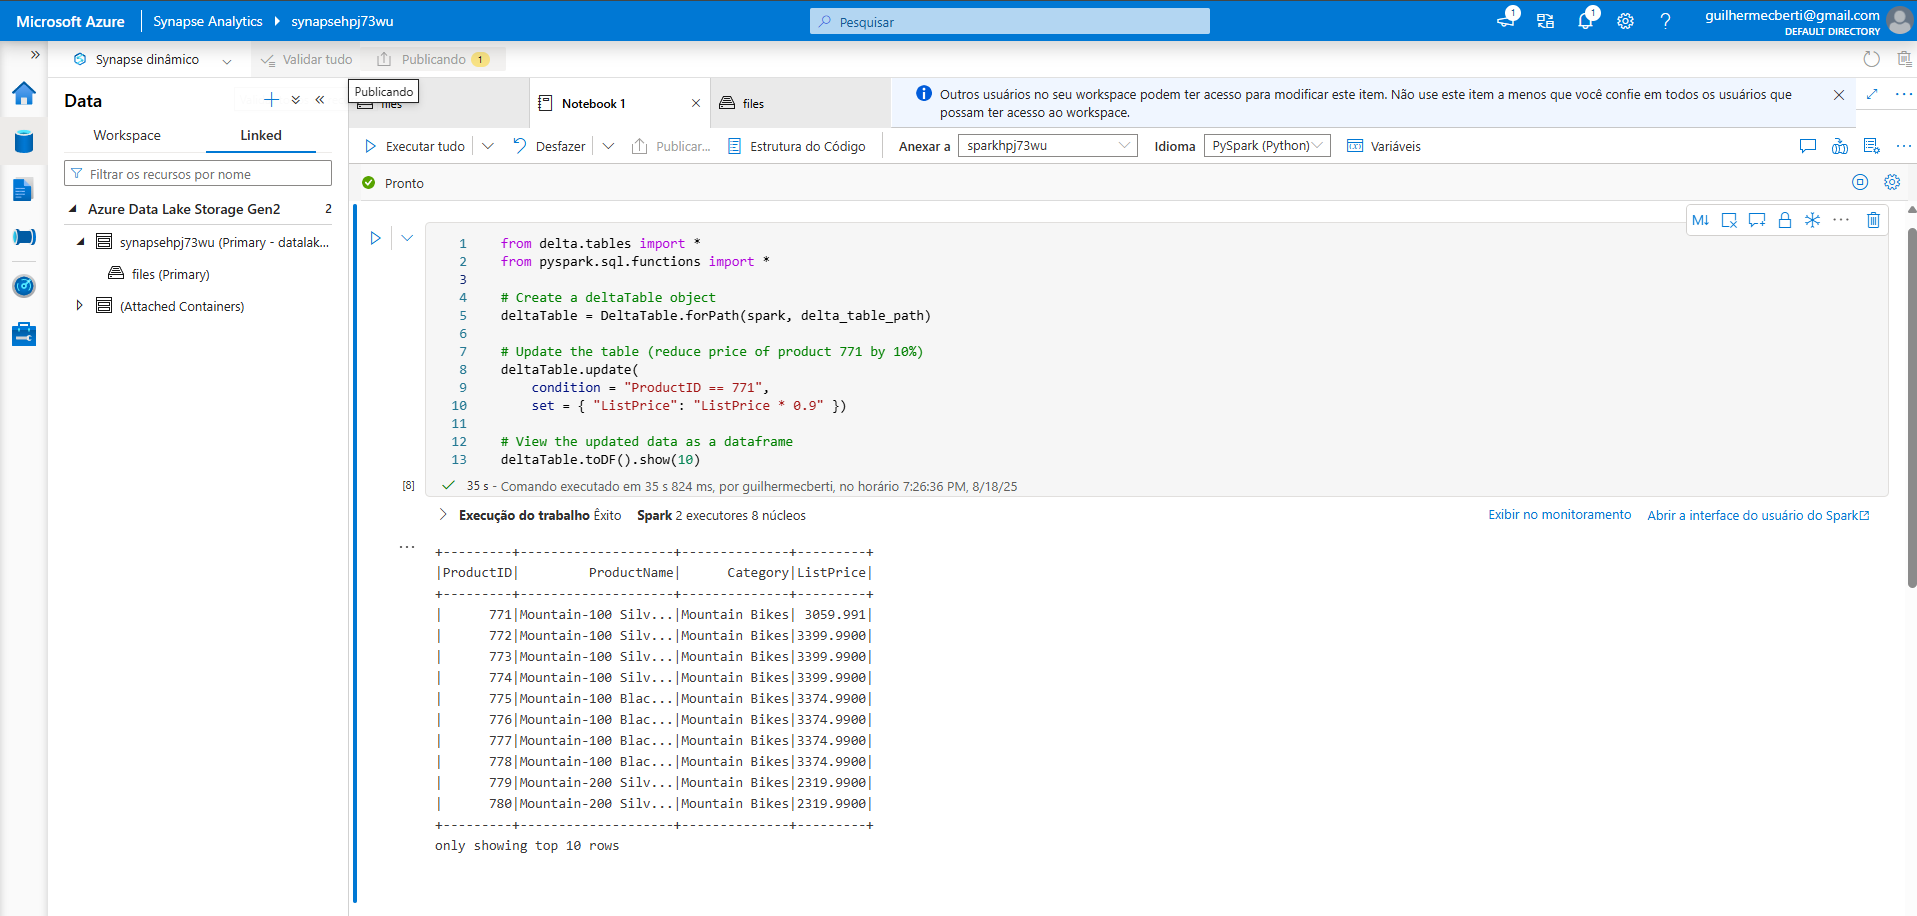

Adicione outra nova célula de código com o seguinte código e execute-a:

In [ ]:
new_df = spark.read.format("delta").load(delta_table_path)
new_df.show(10)

O código carrega os dados da tabela delta em um quadro de dados a partir de sua localização no data lake, verificando se a alteração feita por meio de um objeto DeltaTable foi persistida.

Modifique o código que você acabou de executar da seguinte maneira, especificando a opção de usar o recurso de viagem no tempo do Delta Lake para visualizar uma versão anterior dos dados.

In [ ]:
 new_df = spark.read.format("delta").option("versionAsOf", 0).load(delta_table_path)
 new_df.show(10)

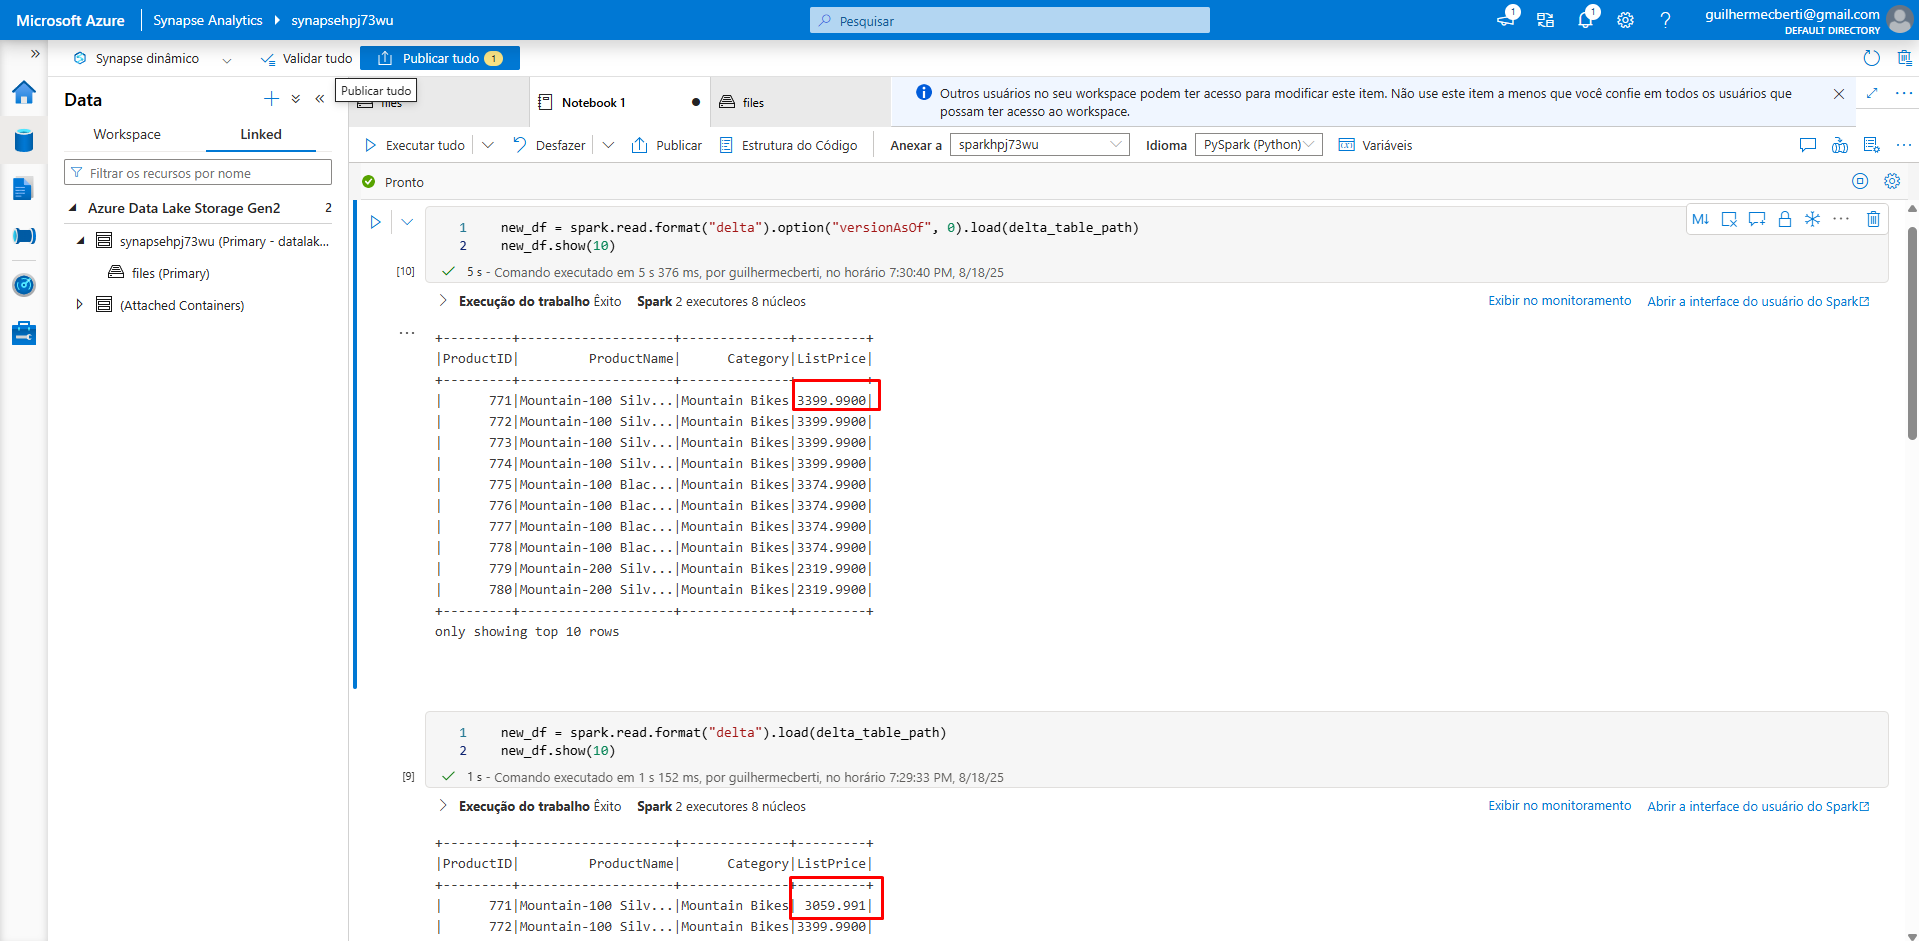

O histórico das últimas 20 alterações na tabela é mostrado — deve haver duas (a criação original e a atualização que você fez):

In [ ]:
 deltaTable.history(10).show(20, False, True)

## Criar tabelas de catálogo

**Criar uma tabela externa**

Em uma nova célula de código, adicione e execute o seguinte código:

In [ ]:
 spark.sql("CREATE DATABASE AdventureWorks")
 spark.sql("CREATE TABLE AdventureWorks.ProductsExternal USING DELTA LOCATION '{0}'".format(delta_table_path))
 spark.sql("DESCRIBE EXTENDED AdventureWorks.ProductsExternal").show(truncate=False)

Este código cria um novo banco de dados chamado AdventureWorks e, em seguida, cria uma tabela externa chamada ProductsExternal nesse banco de dados com base no caminho para os arquivos parquet que você definiu anteriormente.

Em seguida, ele exibe uma descrição das propriedades da tabela. Observe que a propriedade Localização é o caminho que você especificou.

O código usa SQL para alternar o contexto para o banco de dados AdventureWorks (que não retorna dados) e, em seguida, consultar a tabela ProductsExternal (que retorna um conjunto de resultados contendo os dados dos produtos na tabela Delta Lake):

In [ ]:
 %%sql

 USE AdventureWorks;

 SELECT * FROM ProductsExternal;

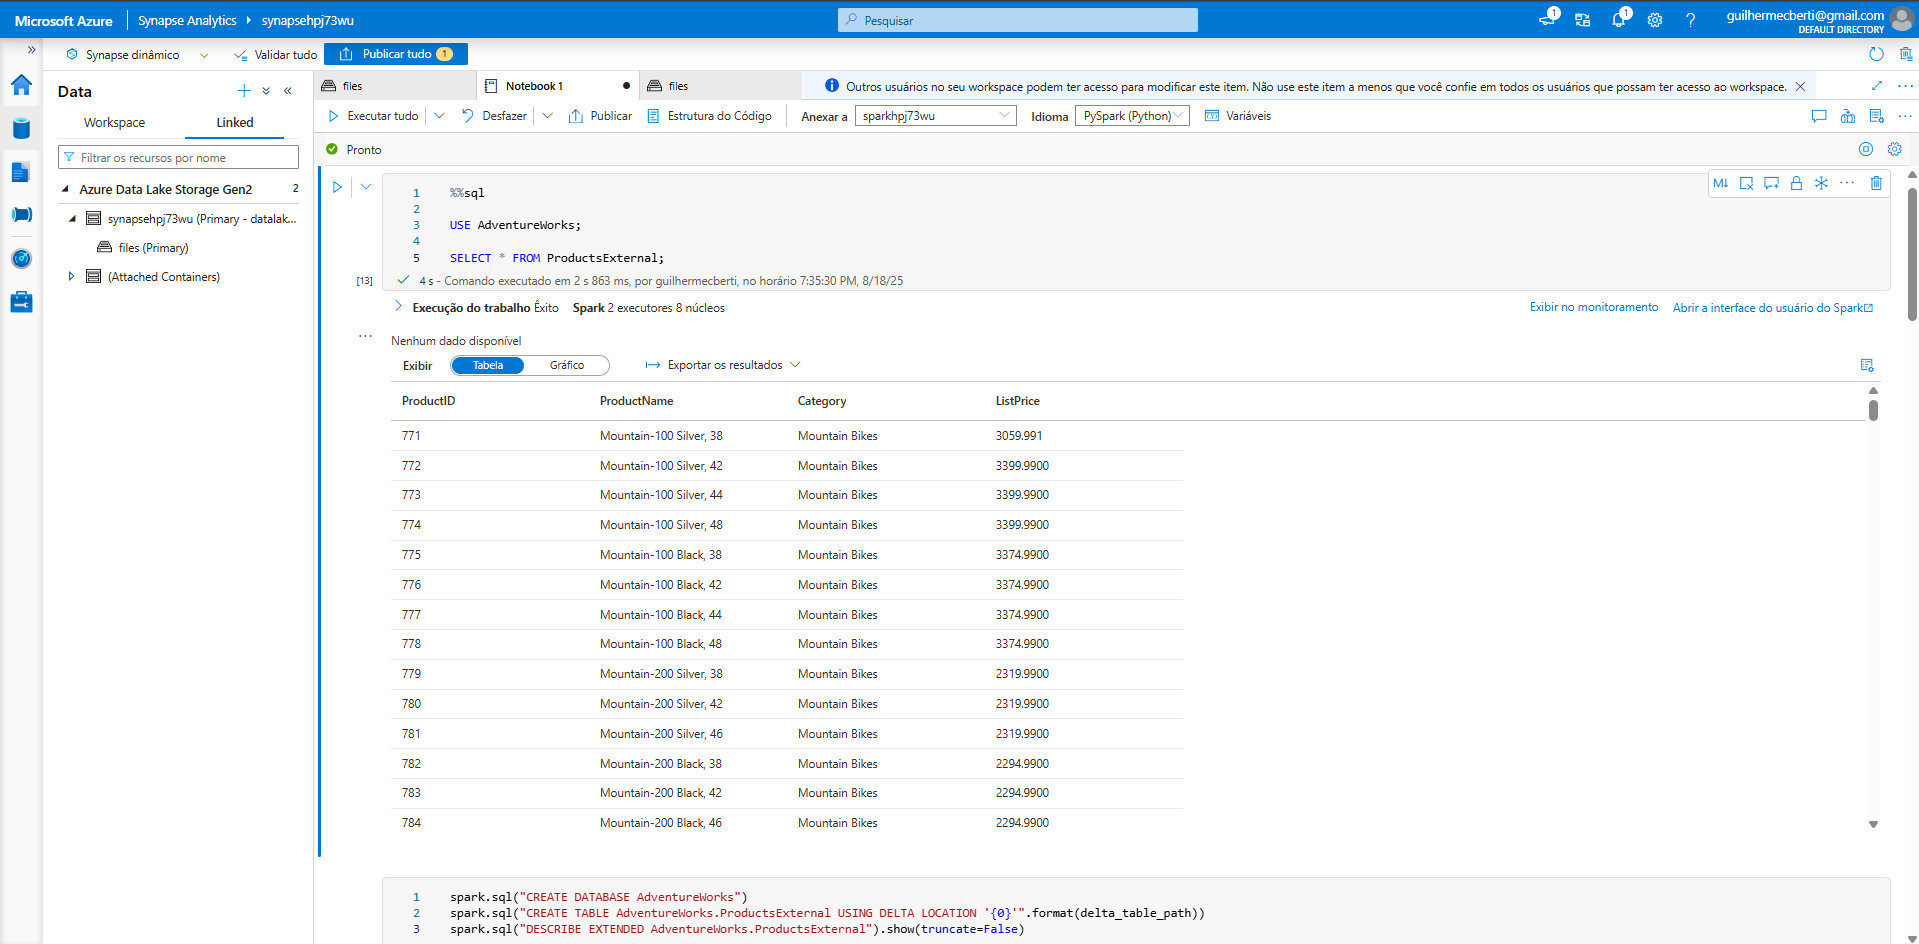

**Criar uma tabela gerenciada**

Este código cria uma tabela gerenciada chamada ProductsManaged com base no DataFrame que você carregou originalmente do arquivo products.csv (antes de atualizar o preço do produto 771).

Não especifique um caminho para os arquivos parquet usados pela tabela. Isso é gerenciado para você no metastore do Hive e mostrado na propriedade Localização na descrição da tabela (no caminho files/synapse/workspaces/synapsexxxxxxx/warehouse)

In [ ]:
 df.write.format("delta").saveAsTable("AdventureWorks.ProductsManaged")
 spark.sql("DESCRIBE EXTENDED AdventureWorks.ProductsManaged").show(truncate=False)

O código usa SQL para consultar a tabela ProductsManaged:

In [ ]:
 %%sql

 USE AdventureWorks;

 SELECT * FROM ProductsManaged;

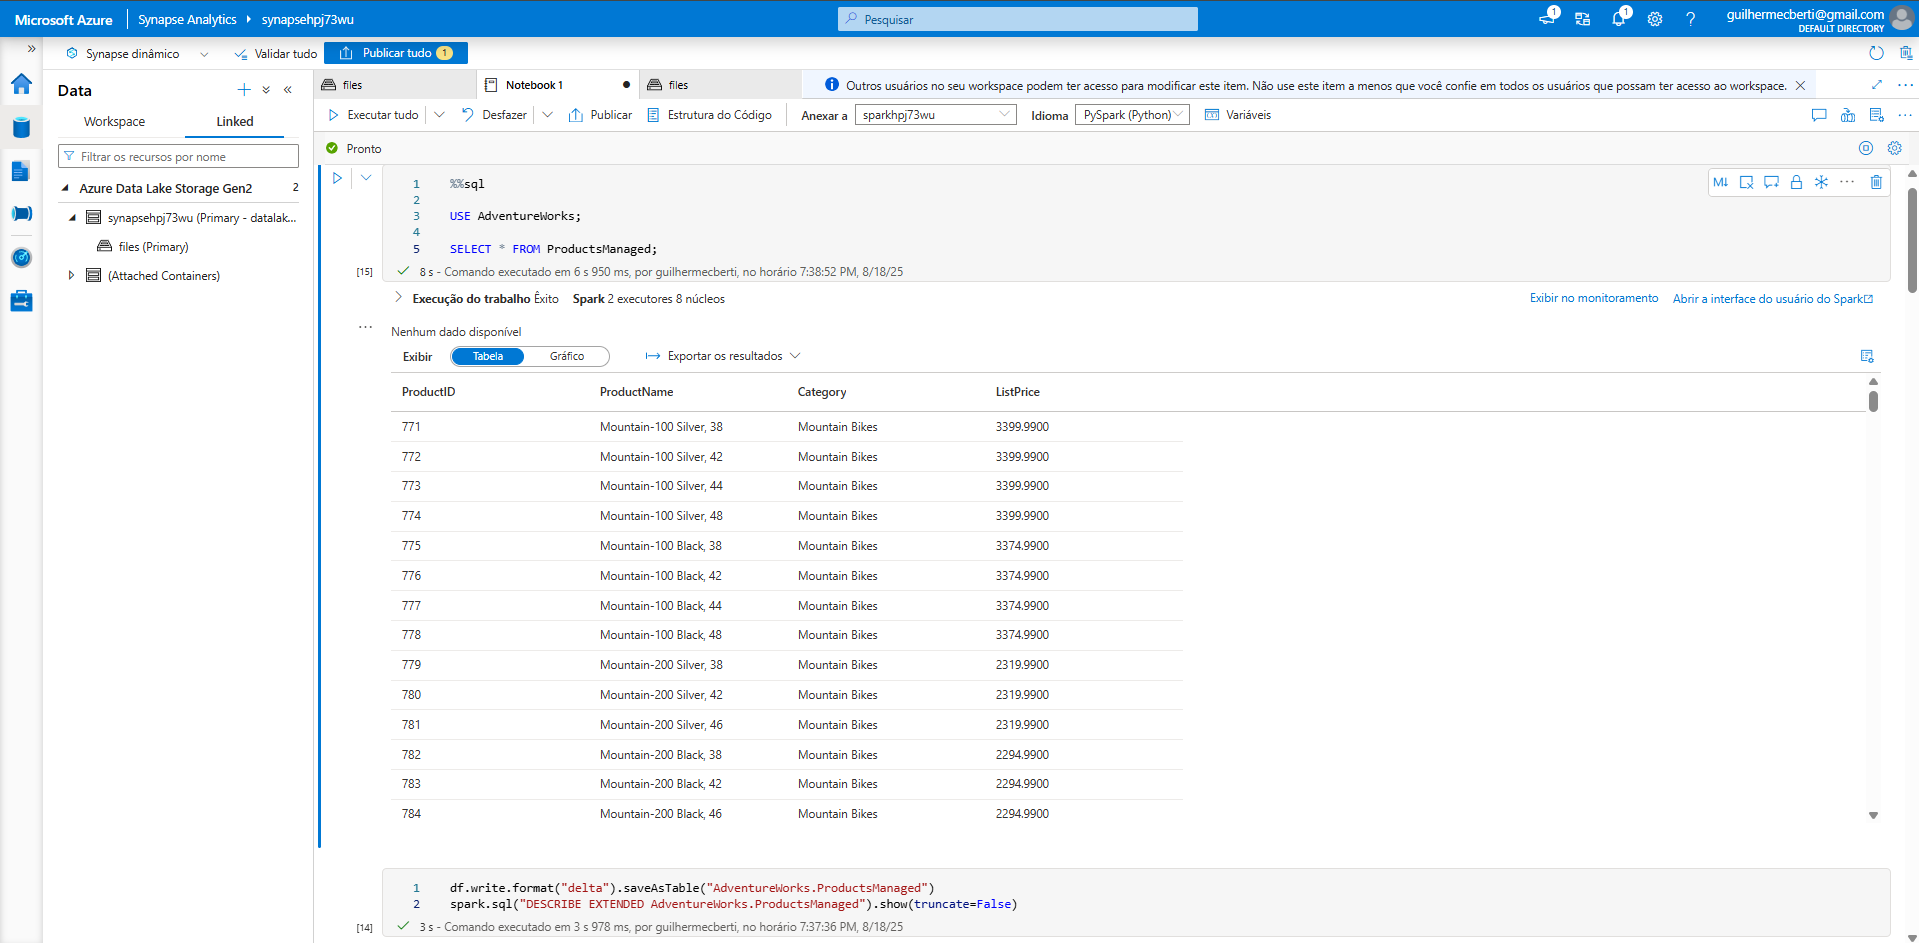

## Use tabelas delta para streaming de dados

O Delta Lake suporta streaming de dados. As tabelas Delta podem ser um coletor ou uma fonte para fluxos de dados criados com a API Spark Structured Streaming.

Neste exemplo, você usará uma tabela delta como um coletor para alguns dados de streaming em um cenário simulado de internet das coisas (IoT).

In [ ]:
 from notebookutils import mssparkutils
 from pyspark.sql.types import *
 from pyspark.sql.functions import *

 # Create a folder
 inputPath = '/data/'
 mssparkutils.fs.mkdirs(inputPath)

 # Create a stream that reads data from the folder, using a JSON schema
 jsonSchema = StructType([
 StructField("device", StringType(), False),
 StructField("status", StringType(), False)
 ])
 iotstream = spark.readStream.schema(jsonSchema).option("maxFilesPerTrigger", 1).json(inputPath)

 # Write some event data to the folder
 device_data = '''{"device":"Dev1","status":"ok"}
 {"device":"Dev1","status":"ok"}
 {"device":"Dev1","status":"ok"}
 {"device":"Dev2","status":"error"}
 {"device":"Dev1","status":"ok"}
 {"device":"Dev1","status":"error"}
 {"device":"Dev2","status":"ok"}
 {"device":"Dev2","status":"error"}
 {"device":"Dev1","status":"ok"}'''
 mssparkutils.fs.put(inputPath + "data.txt", device_data, True)
 print("Source stream created...")

Certifique-se de que a mensagem "Source stream created…" seja impressa. O código que você acabou de executar criou uma fonte de dados de streaming com base em uma pasta na qual alguns dados foram salvos, representando leituras de dispositivos IoT hipotéticos.

Este código grava os dados do dispositivo de streaming no formato delta:

In [ ]:
 # Write the stream to a delta table
 delta_stream_table_path = '/delta/iotdevicedata'
 checkpointpath = '/delta/checkpoint'
 deltastream = iotstream.writeStream.format("delta").option("checkpointLocation", checkpointpath).start(delta_stream_table_path)
 print("Streaming to delta sink...")

Este código lê os dados transmitidos em formato delta para um dataframe. Observe que o código para carregar dados de streaming não é diferente daquele usado para carregar dados estáticos de uma pasta delta:

In [ ]:
 # Read the data in delta format into a dataframe
 df = spark.read.format("delta").load(delta_stream_table_path)
 display(df)

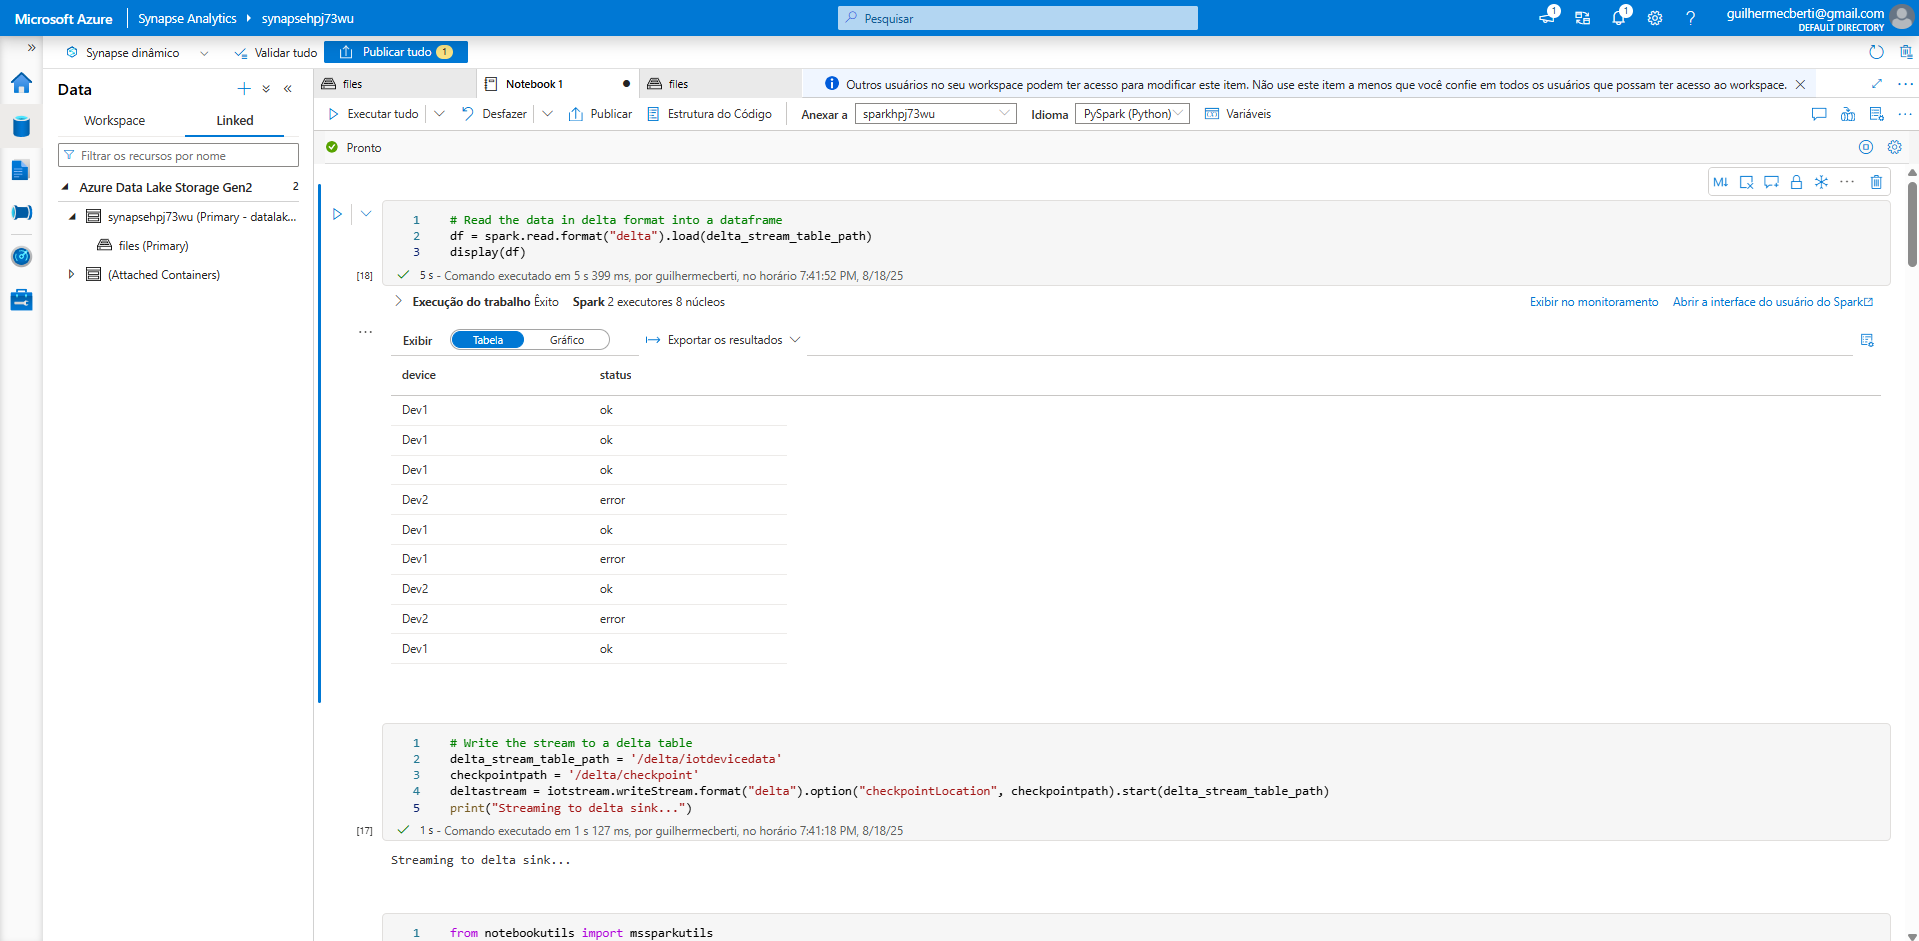

Este código cria uma tabela de catálogo chamada IotDeviceData (no banco de dados padrão) com base na pasta delta. Novamente, este código é o mesmo que seria usado para dados não streaming:

In [ ]:
 # create a catalog table based on the streaming sink
 spark.sql("CREATE TABLE IotDeviceData USING DELTA LOCATION '{0}'".format(delta_stream_table_path))

Consulta:

In [ ]:
 %%sql

 SELECT * FROM IotDeviceData;

Este código interrompe o fluxo:

In [ ]:
 deltastream.stop()